In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import joblib


from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('train.csv')

In [ ]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
amenities = ['VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

<Axes: >

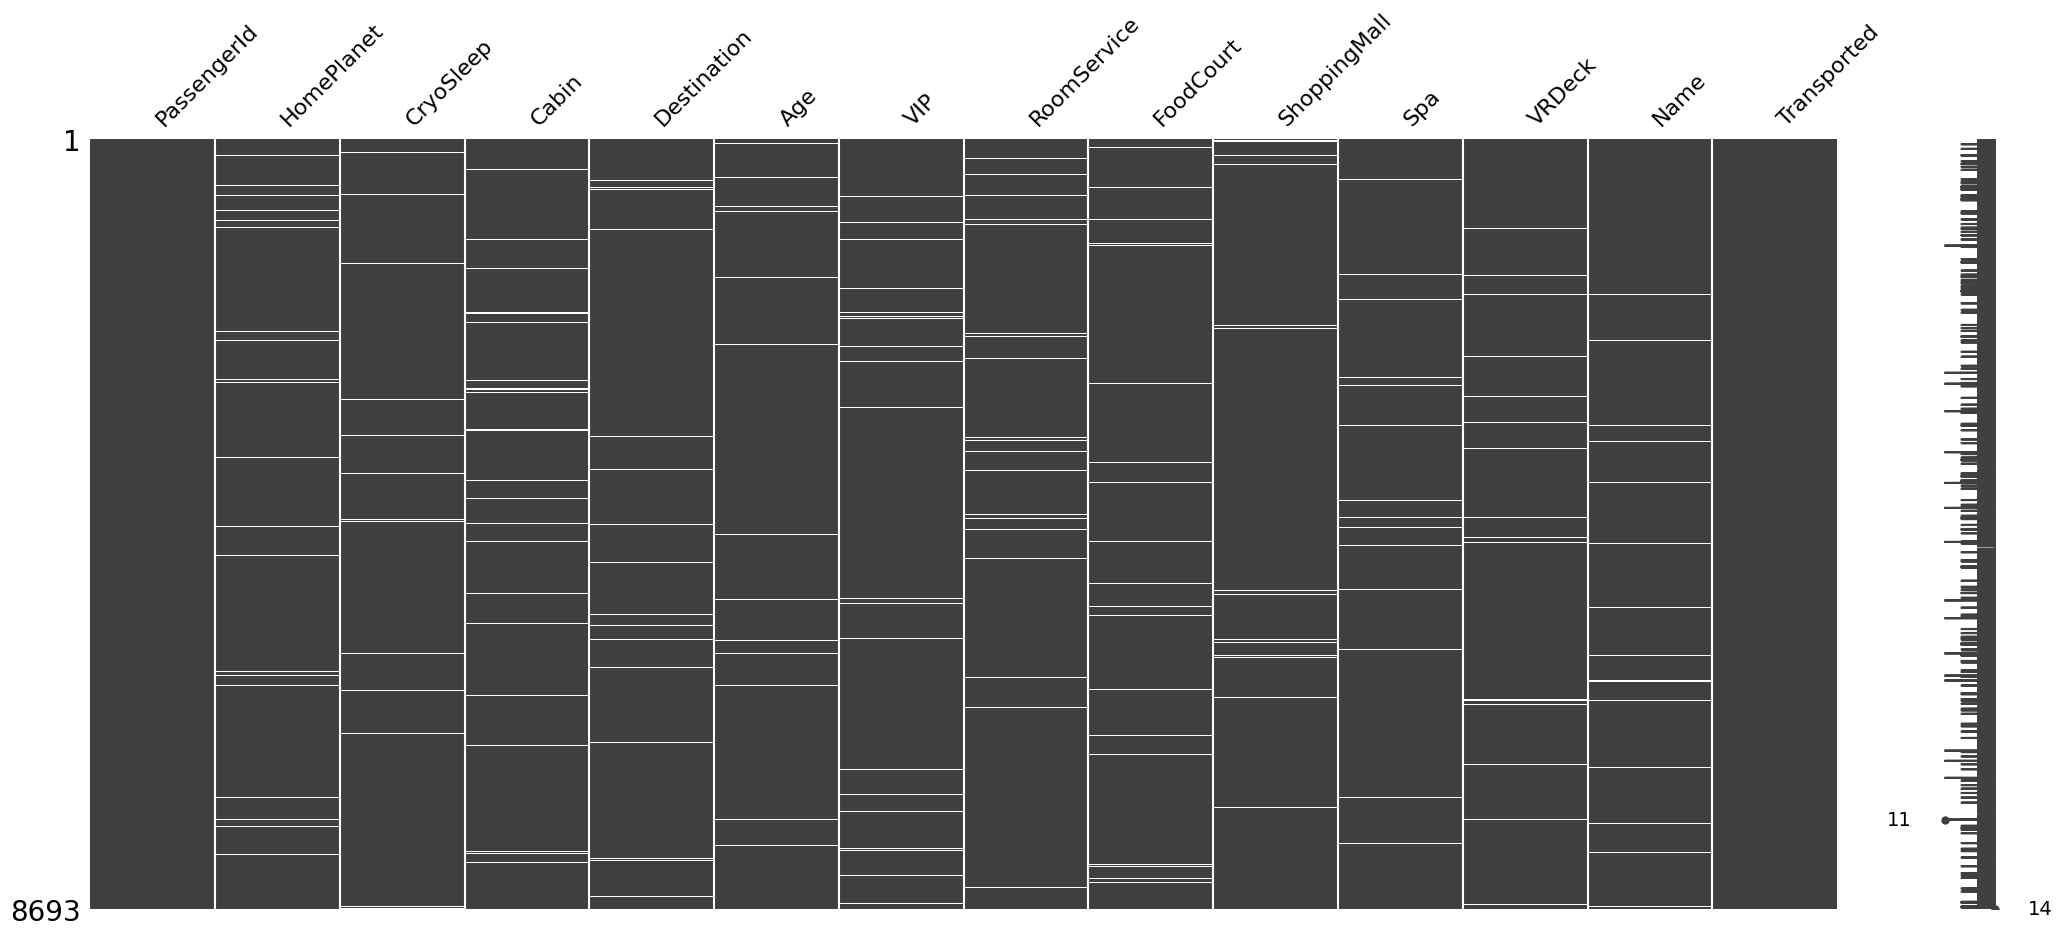

In [6]:
msno.matrix(df)

In [8]:
df[numerical_columns].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
""" 
Para la columna VIP, se estudia la distribución de personas en categoría VIP
Si esta es mucho mayor a la cantidad de personas que no son VIP (más de 90%), se imputara usando el valor de la moda, False
"""

round(df['VIP'].value_counts() / len(df) * 100, 2)

VIP
False    95.38
True      2.29
Name: count, dtype: float64

In [6]:
""" 
Para la columna CryoSleep se busca si hay alguna correlación entre si está en CryoSleep o no y cualquier otra columna del dataset
En este caso, se encontró que las personas que están en CryoSleep, al no estar despiertas, no pagan por las amenidades
Y por el contrario, las personas que no están en CryoSleep, pagan por las amenidades, 
lo que indica que se puede imputar el valor nulo con False si no pagan por las amenidades 
"""
print('Porcentaje de personas en CryoSleep:')
print(round(df['CryoSleep'].value_counts() / len(df) * 100, 2))

print('\nPagos en amenidades de quienes están en CryoSleep:')
print(df[df['CryoSleep'] == True][amenities].max())
print('\nPagos en amenidades de quienes NO están en CryoSleep:')
print(df[df['CryoSleep'] == False][amenities].mean())

Porcentaje de personas en CryoSleep:
CryoSleep
False    62.57
True     34.94
Name: count, dtype: float64

Pagos en amenidades de quienes están en CryoSleep:
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

Pagos en amenidades de quienes NO están en CryoSleep:
RoomService     350.146772
FoodCourt       713.004316
ShoppingMall    270.586504
Spa             486.092940
VRDeck          475.716165
dtype: float64


In [7]:
""" 
Para la columna Age, la hipótesis es que habrá diferencias considerables en los pagos de las amenidades dependiendo de la edad
Además, se espera que la cantidad de personas en categoría VIP por grupo de edad sea distinta y pueda influir en la imputación de valores nulos
"""

adultos = df[df['Age'] >= 38]
ninos = df[df['Age'] < 19]
jovenes = df[(df['Age'] >= 19) & (df['Age'] < 38)]

print('Pagos en amenidades de adultos:')
print(adultos[amenities].mean())
print('Cantidad de adultos en VIP:', adultos['VIP'].sum())

print('\nPagos en amenidades de jóvenes:')
print(jovenes[amenities].mean())
print('Cantidad de jóvenes en VIP:', jovenes['VIP'].sum())

print('\nPagos en amenidades de niños:')
print(ninos[amenities].mean())
print('Cantidad de niños en VIP:', ninos['VIP'].sum())

Pagos en amenidades de adultos:
RoomService     254.598109
FoodCourt       661.309693
ShoppingMall    179.613712
Spa             460.241852
VRDeck          406.170859
dtype: float64
Cantidad de adultos en VIP: 74

Pagos en amenidades de jóvenes:
RoomService     253.571915
FoodCourt       512.697515
ShoppingMall    195.558938
Spa             324.931176
VRDeck          348.477975
dtype: float64
Cantidad de jóvenes en VIP: 123

Pagos en amenidades de niños:
RoomService     125.637514
FoodCourt        96.807965
ShoppingMall    121.570099
Spa             101.278051
VRDeck           84.201209
dtype: float64
Cantidad de niños en VIP: 1


In [8]:
""" 
Para la columna Cabin, primero se separará en Deck y Side, que son los datos que se tienen en la columna
"""

def separate_cabin(df):
    df[['CabinDeck', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)[[0, 2]]
    df.drop('Cabin', axis=1, inplace=True)
    return df

df = separate_cabin(df)
categorical_columns = categorical_columns.drop('Cabin').append(pd.Index(['CabinDeck', 'CabinSide']))

display(df[['CabinDeck', 'CabinSide']].describe())
df[['CabinDeck', 'CabinSide']].isnull().sum()

,CabinDeck,CabinSide
count,8494,8494
unique,8,2
top,F,S
freq,2794,4288


CabinDeck    199
CabinSide    199
dtype: int64

In [9]:
""" 
Se intenta encontrar si hay alguna correlación entre el Deck y el Side de la cabina con alguna otra columna
"""

port = df[df['CabinSide'] == 'P']
starboard = df[df['CabinSide'] == 'S']

print('VIPs en port:', port['VIP'].sum())
print('VIPs en starboard:', starboard['VIP'].sum())

print('\nPagos en amenidades de port:')
print(port[amenities].mean())

print('\nPagos en amenidades de starboard:')
print(starboard[amenities].mean())

VIPs en port: 102
VIPs en starboard: 91

Pagos en amenidades de port:
RoomService     229.917072
FoodCourt       425.092080
ShoppingMall    187.635786
Spa             304.329529
VRDeck          315.586349
dtype: float64

Pagos en amenidades de starboard:
RoomService     214.168371
FoodCourt       490.235238
ShoppingMall    162.091970
Spa             308.874613
VRDeck          296.849750
dtype: float64


## Imputaciones

In [10]:
""" 
Para las variables numéricas, se hará la siguiente transformación:
- Para Age y las amenidades, se hará una estandarización para generar una distribución normal

Para las variables categóricas, se hará la siguiente transformación:
- CryoSleep y VIP se codificarán como 0 y 1, 0 para False y 1 para True
- Para HomePlanet y Destination, se hará una codificación OneHot para cada planeta con drop='if_binary'
- Para CabinDeck y CabinSide, se hará una codificación OneHot para cada Deck y Side con drop='if_binary'
"""

# Las columnas de PassengerId y Name no aportan información relevante, por lo que se eliminan
df = df.drop(columns=['PassengerId', 'Name'])

# Asumimos que, cualquier valor nulo en las columnas de las amenidades, es porque el pasajero no pago por ninguna de ellas
df[amenities] = df[amenities].fillna(0.0)

# La columna VIP se llenará con el valor False, ya que, por mucho (95%), la mayoría de los pasajeros no son VIP
df['VIP'] = df['VIP'].fillna(False)

# La columna CryoSleep se llenará con False si alguna de las amenidades es mayor a 0, True en caso contrario
df['CryoSleep'] = df['CryoSleep'].fillna(df.apply(lambda row: False if any(row[amenities] > 0) else True, axis=1))

# Las columnas de Deck y Side de la cabina se llenarán con la moda
df['CabinDeck'] = df['CabinDeck'].fillna(df['CabinDeck'].mode()[0])
df['CabinSide'] = df['CabinSide'].fillna(df['CabinSide'].mode()[0])

""" 
- KNN Imputer a Destination y HomePlanet ya que las demás variables pueden influir en el dato faltante
- KNN Imputer a Age, ya que se espera que, como se mostró anteriormente, la edad influya en los pagos de las amenidades y en la categoría VIP
"""

df['Destination'] = df['Destination'].astype('category').cat.codes
df['HomePlanet'] = df['HomePlanet'].astype('category').cat.codes

imputer = KNNImputer(n_neighbors=5)
df[['Destination', 'HomePlanet', 'Age']] = imputer.fit_transform(df[['Destination', 'HomePlanet', 'Age']])

C:\Users\User\AppData\Local\Temp\ipykernel_10124\3228961303.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False)
C:\Users\User\AppData\Local\Temp\ipykernel_10124\3228961303.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(df.apply(lambda row: False if any(row[amenities] > 0) else True, axis=1))


## OneHot Encoder

In [11]:
ohe = OneHotEncoder(sparse_output=False, drop='first') 
categorical_columns = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'CabinDeck', 'CabinSide']
encoded_features = ohe.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(categorical_columns))

df = pd.concat([df, encoded_df], axis=1)
df = df.drop(columns=categorical_columns)
df['Transported'] = df['Transported'].astype('category').cat.codes

# Modelos

In [12]:
X = df.drop('Transported', axis=1)
y = df['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost

In [21]:
xgb = XGBClassifier()

grid_values = {'n_estimators': [600, 1000, 1500], 'learning_rate': [0.01],
                'max_depth': [2, 3, 4], 'subsample': [0.6, 0.75, 0.8]}
grid_clf = GridSearchCV(xgb, param_grid = grid_values, scoring = 'precision')
grid_clf.fit(X_train, y_train)

# Obtain best parameters
best_parameters = grid_clf.best_params_

# Store parameters in a dataframe
pd.DataFrame.from_dict(best_parameters, orient='index', columns=['Assigned Value']).sort_index()

,Assigned Value
learning_rate,0.01
max_depth,4.00
n_estimators,1500.00
subsample,0.60


XGBoost:
Accuracy en el conjunto completo: 0.8325
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83      4315
           1       0.82      0.85      0.84      4378

    accuracy                           0.83      8693
   macro avg       0.83      0.83      0.83      8693
weighted avg       0.83      0.83      0.83      8693



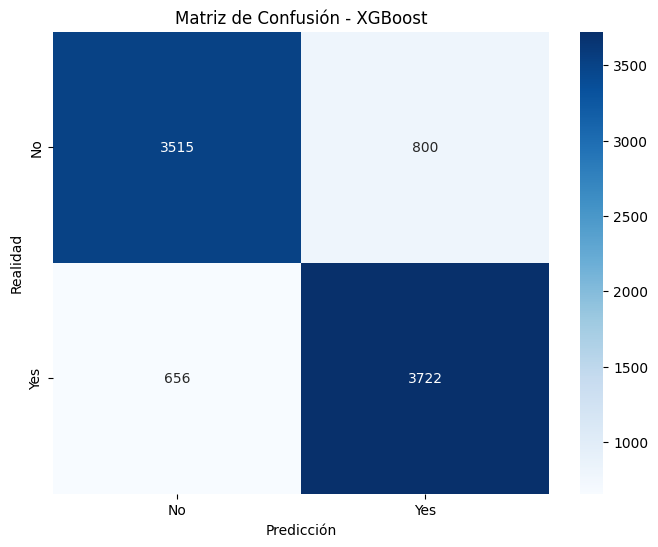

In [13]:
xgb = XGBClassifier(n_estimators=1500, learning_rate=0.01, max_depth=4, subsample=0.6, random_state=1)

# Validación cruzada para el descenso de gradiente
cv_scores_xgb = cross_val_score(xgb, X, y, cv=10, scoring='precision')
# Entrenamiento final del modelo de descenso de gradiente en todo el conjunto de datos
xgb.fit(X, y)

# Obtener predicciones en el conjunto completo para la matriz de confusión
y_pred_xgb = xgb.predict(X)
cm_xgb = confusion_matrix(y, y_pred_xgb)

accuracy_xgb = accuracy_score(y, y_pred_xgb)

print("XGBoost:")
print(f"Accuracy en el conjunto completo: {accuracy_xgb:.4f}")
print('Reporte de Clasificación:\n', classification_report(y, y_pred_xgb))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Voting con XGBoost, KNN y AdaBoost

Voting Classifier:
Accuracy en el conjunto completo: 0.8269
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      4315
           1       0.81      0.85      0.83      4378

    accuracy                           0.83      8693
   macro avg       0.83      0.83      0.83      8693
weighted avg       0.83      0.83      0.83      8693



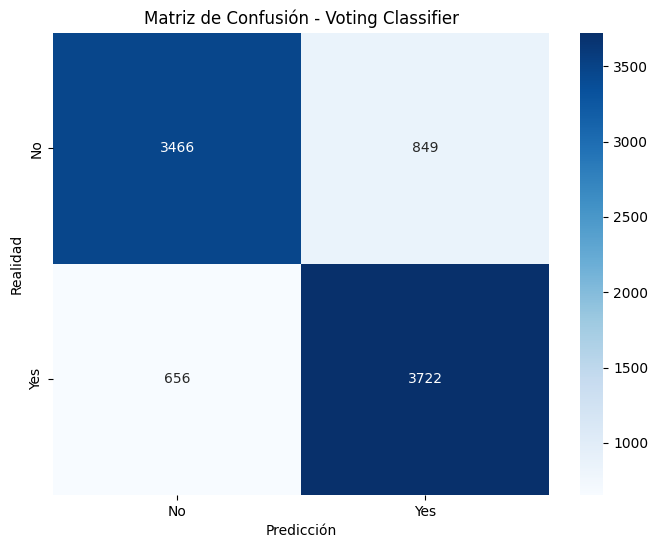

In [25]:
xgb = XGBClassifier(n_estimators=800, learning_rate=0.01, max_depth=4, subsample=0.75, random_state=1)
ada = AdaBoostClassifier(n_estimators=600, learning_rate=0.01, algorithm='SAMME', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

vc = VotingClassifier(estimators=[('xgb', xgb), ('ada', ada), ('knn', knn)], voting='soft')

# Validación cruzada para el descenso de gradiente
cv_scores_vc = cross_val_score(vc, X, y, cv=10, scoring='precision')
# Entrenamiento final del modelo de descenso de gradiente en todo el conjunto de datos
vc.fit(X, y)

# Obtener predicciones en el conjunto completo para la matriz de confusión
y_pred_vc = vc.predict(X)
cm_vc = confusion_matrix(y, y_pred_vc)

accuracy_vc = accuracy_score(y, y_pred_vc)

print("Voting Classifier:")
print(f"Accuracy en el conjunto completo: {accuracy_vc:.4f}")

# Classification Report
print('Reporte de Clasificación:\n', classification_report(y, y_pred_vc))
# Visualización de la matriz de confusión para el descenso de gradiente
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vc, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Matriz de Confusión - Voting Classifier')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Voting con CatBoost, KNN y AdaBoost

Voting Classifier:
Accuracy en el conjunto completo: 0.8269
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      4315
           1       0.81      0.85      0.83      4378

    accuracy                           0.83      8693
   macro avg       0.83      0.83      0.83      8693
weighted avg       0.83      0.83      0.83      8693



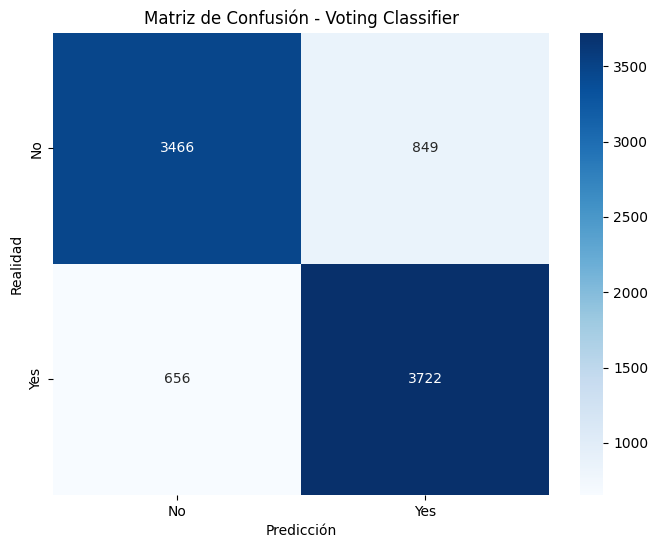

In [30]:
cat = CatBoostClassifier(depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.1, random_state=42)
ada = AdaBoostClassifier(n_estimators=600, learning_rate=0.01, algorithm='SAMME', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

vc2 = VotingClassifier(estimators=[('xgb', xgb), ('ada', ada), ('knn', knn)], voting='soft')

# Validación cruzada para el descenso de gradiente
cv_scores_vc = cross_val_score(vc2, X, y, cv=10, scoring='precision')
# Entrenamiento final del modelo de descenso de gradiente en todo el conjunto de datos
vc2.fit(X, y)

# Obtener predicciones en el conjunto completo para la matriz de confusión
y_pred_vc2 = vc2.predict(X)
cm_vc2 = confusion_matrix(y, y_pred_vc2)

accuracy_vc = accuracy_score(y, y_pred_vc2)

print("Voting Classifier:")
print(f"Accuracy en el conjunto completo: {accuracy_vc:.4f}")

# Classification Report
print('Reporte de Clasificación:\n', classification_report(y, y_pred_vc2))
# Visualización de la matriz de confusión para el descenso de gradiente
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vc2, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Matriz de Confusión - Voting Classifier')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

## Predicción con nuevos datos

In [33]:
"""
HomePlanet: 'Europa', 'Earth', 'Mars'
CryoSleep: Sí, No
Destination: 'TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'
VIP: Sí, No
CabinDeck: 'B', 'F', 'A', 'G', 'E', 'D', 'C', 'T'
CabinSide: 'P', 'S'

Age: sin opción 
RoomService: sin opción (puede ser random, si CryoSleep es True, este tiene que ser 0)
FoodCourt: sin opción (puede ser random, si CryoSleep es True, este tiene que ser 0)
ShoppingMall: sin opción (puede ser random, si CryoSleep es True, este tiene que ser 0)
Spa: sin opción (puede ser random, si CryoSleep es True, este tiene que ser 0)
VRDeck: sin opción (puede ser random, si CryoSleep es True, este tiene que ser 0)
"""
pd.set_option('future.no_silent_downcasting', True)

homeplanet = input('HomePlanet Europa (1), Earth (2), Mars (3): ')
cryosleep = input('CryoSleep Sí (1), No (2): ')
destination = input('Destination TRAPPIST-1e (1), PSO J318.5-22 (2), 55 Cancri e (3): ')
vip = input('VIP Sí (1), No (2): ')
cabindeck = input('CabinDeck B (1), F (2), A (3), G (4), E (5), D (6), C (7), T (8): ')
cabinside = input('CabinSide Port (1), Starboard (2): ')
age = input('Age: ')

if cryosleep == '1':
    roomservice = 0
    foodcourt = 0
    shoppingmall = 0
    spa = 0
    vrdeck = 0
else:
    roomservice = input('RoomService: ')
    foodcourt = input('FoodCourt: ')
    shoppingmall = input('ShoppingMall: ')
    spa = input('Spa: ')
    vrdeck = input('VRDeck: ')

point = pd.DataFrame({
    'HomePlanet': [homeplanet],
    'CryoSleep': [cryosleep],
    'Destination': [destination],
    'VIP': [vip],
    'CabinDeck': [cabindeck],
    'CabinSide': [cabinside],
    'Age': [age],
    'RoomService': [roomservice],
    'FoodCourt': [foodcourt],
    'ShoppingMall': [shoppingmall],
    'Spa': [spa],
    'VRDeck': [vrdeck]
})

model = joblib.load('model_xgboost.pkl')

# Crear DataFrame vacío con las columnas deseadas
df_predict = pd.DataFrame(columns=['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 
                                   'HomePlanet_0.0', 'HomePlanet_1.0', 'HomePlanet_2.0', 
                                   'Destination_0.0', 'Destination_1.0', 'Destination_2.0', 
                                   'CryoSleep_True', 'VIP_True', 
                                   'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_D', 'CabinDeck_E', 
                                   'CabinDeck_F', 'CabinDeck_G', 'CabinDeck_T', 
                                   'CabinSide_S'])

# Asignar valores a las columnas del DataFrame df_predict
df_predict['Age'] = point['Age']
df_predict['RoomService'] = point['RoomService']
df_predict['FoodCourt'] = point['FoodCourt']
df_predict['ShoppingMall'] = point['ShoppingMall']
df_predict['Spa'] = point['Spa']
df_predict['VRDeck'] = point['VRDeck']

# Asignar valores a las columnas categóricas
df_predict.loc[0, 'HomePlanet_0.0'] = 1 if point['HomePlanet'][0] == '1' else 0
df_predict.loc[0, 'HomePlanet_1.0'] = 1 if point['HomePlanet'][0] == '2' else 0
df_predict.loc[0, 'HomePlanet_2.0'] = 1 if point['HomePlanet'][0] == '3' else 0

df_predict.loc[0, 'Destination_0.0'] = 1 if point['Destination'][0] == '1' else 0
df_predict.loc[0, 'Destination_1.0'] = 1 if point['Destination'][0] == '2' else 0
df_predict.loc[0, 'Destination_2.0'] = 1 if point['Destination'][0] == '3' else 0

df_predict.loc[0, 'CryoSleep_True'] = 1 if point['CryoSleep'][0] == '1' else 0
df_predict.loc[0, 'VIP_True'] = 1 if point['VIP'][0] == '1' else 0

df_predict.loc[0, 'CabinDeck_B'] = 1 if point['CabinDeck'][0] == '1' else 0
df_predict.loc[0, 'CabinDeck_C'] = 1 if point['CabinDeck'][0] == '2' else 0
df_predict.loc[0, 'CabinDeck_D'] = 1 if point['CabinDeck'][0] == '3' else 0
df_predict.loc[0, 'CabinDeck_E'] = 1 if point['CabinDeck'][0] == '4' else 0
df_predict.loc[0, 'CabinDeck_F'] = 1 if point['CabinDeck'][0] == '5' else 0
df_predict.loc[0, 'CabinDeck_G'] = 1 if point['CabinDeck'][0] == '6' else 0
df_predict.loc[0, 'CabinDeck_T'] = 1 if point['CabinDeck'][0] == '7' else 0

df_predict.loc[0, 'CabinSide_S'] = 1 if point['CabinSide'][0] == '1' else 0

# Llenar valores faltantes con 0
df_predict = df_predict.fillna(0)

# Hacer predicción
df_predict['Transported'] = model.predict(df_predict)
df_predict['Transported'] = df_predict['Transported'].replace({1: 'True', 0: 'False'})

# Mensajes de salida
import time
print('... Calculando ...')
time.sleep(2)
print('... Procesando ...')
time.sleep(1)
print('... Listo ...')
time.sleep(1)

GREEN = '\033[92m'
RED = '\033[91m'
RESET = '\033[0m'

if df_predict['Transported'][0] == 'True':
        print(f'{GREEN}\nEl pasajero HA SIDO TRANSPORTADO a una dimensión alternativa.{RESET}\nEstamos coordinando los esfuerzos para su rescate y asegurarnos de su bienestar.')
else:
    print(f'{RED}\nEl pasajero NO HA SIDO TRANSPORTADO.{RESET}\nQueremos que se sienta seguro, y estamos dedicados a garantizar su bienestar en todo momento.')

time.sleep(1)
print('\nGracias por confiar en nosotros, y recuerde que su seguridad es nuestra prioridad.')

... Calculando ...
... Procesando ...
... Listo ...

El pasajero HA SIDO TRANSPORTADO a una dimensión alternativa.
Estamos coordinando los esfuerzos para su rescate y asegurarnos de su bienestar.

Gracias por confiar en nosotros, y recuerde que su seguridad es nuestra prioridad.
